## Introduction
In this notebook we will create the dataset class used to feed slices and corresponding segmentation masks to the network during training.
It is identical to the CardiacDataset

## Imports

* pathlib for easy path handling
* torch for dataset creation
* numpy for file loading and processing
* imgaug for data augmentation
* matplotlib for demo

In [1]:
from pathlib import Path

import torch
import numpy as np
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import matplotlib.pyplot as plt

## DataSet Creation
We need to implement the following functionality:
1. Create a list of all 2D slices. To so we need to extract all slices from all subjects
2. Extract the corresponding label path for each slice path
3. Load slice and label
4. Data Augmentation. Make sure that slice and mask are augmented identically. imgaug handles this for us, thus we will not use torchvision.transforms for that
5. Return slice and mask

In [2]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject/"data"  # Get the slices for current subject
            for slice in slice_path.glob("*"):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)
        #####################################################
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)
        

Now we can test our dataset!
Let us at first define the data augmentation routine corresponding of scaling and rotation

In [3]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)),  # rotate up to 45 degrees
    iaa.ElasticTransformation()
                ])


In [4]:
# Create the dataset object
path = Path("Task06_Lung/Preprocessed/train/")
dataset = LungDataset(path, seq)

Finally we can visualize our dataset.
To make sure that the augmentation works we access the same element multiple times and check whether the segmentation masks fit

C:\Users\jaikr\.conda\envs\Jupyter_1\lib\site-packages\imgaug\imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


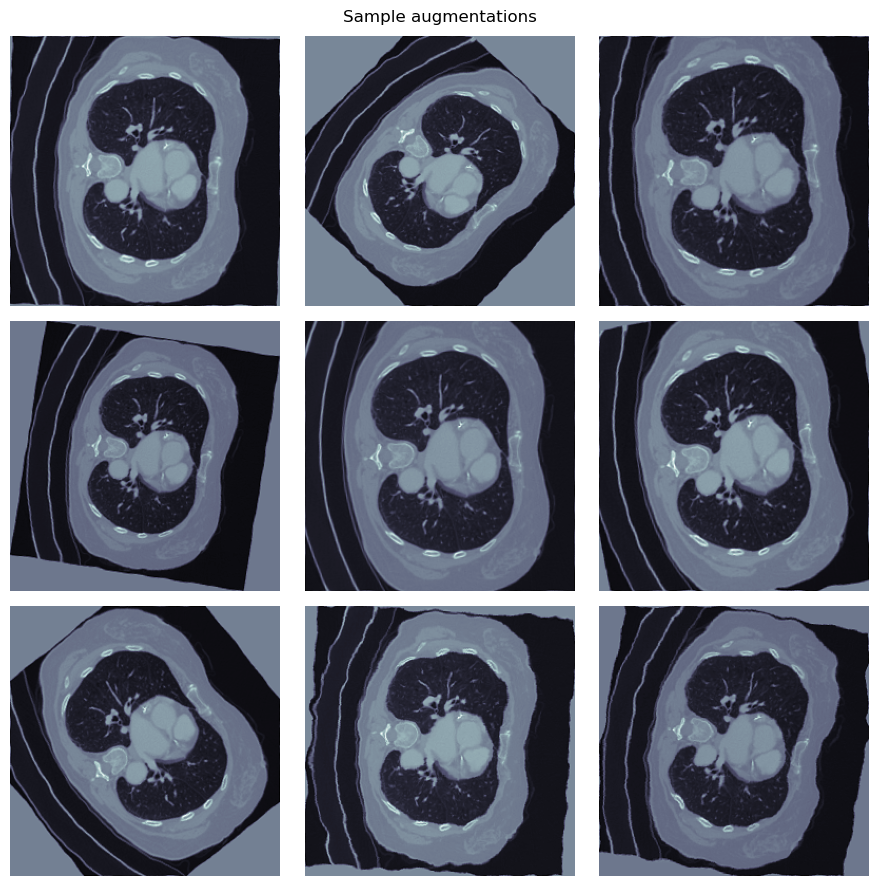

In [5]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[19]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()


Nice!
With above dataset we can finally create the model and train the Lung Cancer Segmentation Model